In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import re
import os
import os.path as osp
import sys
import time
import glob
import cv2
from pathlib import Path
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import OrderedDict


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split, Subset

import torchvision
from torchvision import datasets, models

from mpl_toolkits.axes_grid1 import ImageGrid

from dataset import CVATDataset, COCODataset
from dataset import variable_shape_collate_fn
import transforms
from transforms import BoundingBoxFormatConvert,ToX1y1x2y2Abs, ToCxcywhRel, ToIaa, iaa_hsv_aug, iaa_random_crop, iaa_letterbox, \
                       IaaAugmentations, ToNp, IaaLetterbox, ToTensor, Compose
from boundingbox import bbox_x1y1x2y2_to_xywh, bbox_x1y1x2y2_to_cxcywh, bbox_cxcywh_to_x1y1x2y2, bbox_cxcywh_to_xywh, \
                        bbox_xywh_to_cxcywh, bbox_xywh_to_x1y1x2y2, CoordinateType, FormatType, BoundingBoxConverter
from imgaug import augmenters as iaa
from utils import postprocessing, letterbox_transforms, letterbox_label_reverse
from draw import show_img, draw_rect, draw_text, \
                 cv2_drawTextWithBkgd, get_color_pallete
from darknet import YoloNet
from train import *



# Paths

In [2]:
weight_path = './yolov3.weights'
backbone_weight_path = './darknet53.conv.74'
classes_path = './x_wing.names'
classes_names = ['x_wing', 'tie']
cvat_img_dir = './custom_data/x_wing'
label_xml_path = './custom_data/7_x_wing.xml'
output_dir = './output'

In [3]:
cv2.setNumThreads(0)

# Training

## Set up dataloader

In [4]:
def getTransforms(dim, bbs_idx=np.arange(0,4),
                  coord_type=CoordinateType.Relative, format_type=FormatType.cxcywh, aug=True):
    if aug:
        transform = Compose([ToX1y1x2y2Abs(coord_type, format_type, bbs_idx),
                             ToIaa(bbs_idx),
                             IaaAugmentations([iaa_hsv_aug(0.1, 1.5, 1.5),
                                               iaa_random_crop(0.3),
                                               iaa.Fliplr(0.5)
                                              ]),
                             IaaLetterbox(dim),
                             ToNp(bbs_idx),
                             ToCxcywhRel(CoordinateType.Absolute, FormatType.x1y1x2y2, bbs_idx),
                             ToTensor()])
    else:
        transform = Compose([ToX1y1x2y2Abs(coord_type, format_type, bbs_idx),
                             ToIaa(bbs_idx),
                             IaaLetterbox(dim),
                             ToNp(bbs_idx),
                             ToCxcywhRel(CoordinateType.Absolute, FormatType.x1y1x2y2, bbs_idx),
                             ToTensor()])
    return transform

In [5]:
def getData(sz, bs, subset_idx=None, shuffle=True, isAug=True):
    dim = (sz, sz)
    
    transform = getTransforms(dim, bbs_idx=np.arange(1,5),
                              coord_type=CoordinateType.Absolute, format_type=FormatType.cxcywh, aug=isAug)
    
    train_ds = CVATDataset(cvat_img_dir, label_xml_path, dim=dim, transform=transform)
    if subset_idx is not None:
        train_ds = Subset(train_ds, subset_idx)   

    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=shuffle, collate_fn=variable_shape_collate_fn, num_workers=4)
    
    dataloader = dict()
    dataloader['train'] = train_dl
    dataloader['valid'] = None
    
    return dataloader

## Initial training

In [7]:
sz = 416
# Optimizer parameters
ratio = 1
lr = 0.001 / ratio
darknet53_lr = 0.0001 / ratio
momentum=0.9
wd=0.0005
# Network paramters. Increase subdivisions if GPU don't have enough memory
net_bs = 64
net_subdivisions = 4
bs = int(net_bs / net_subdivisions)
# Learning rate scheduler parameters. Not used at the moment
lr_scheduler_decay_step = 20
lr_scheduler_decay_gamma = 0.1

In [8]:
epoch = 260
model_id = 'x_wing_5'
weight_dir = './weights'

remove_checkpoints(model_id, weight_dir)

net = YoloNet((sz, sz), numClass=2).cuda()
net.feature.loadWeight(backbone_weight_path)

train(getData(sz, bs, shuffle=True, isAug=False), net, epoch,
              lr, darknet53_lr, 
              wd=wd, momentum=momentum, freeze_backbone=False,
              lr_step_decay=0, lr_step_gamma=0,
              net_bs=net_bs, net_subdivisions=net_subdivisions,
              model_id=model_id, start_epoch=0, weight_dir=weight_dir, checkpoint_interval=20,
              resume_checkpoint=None,
              use_gpu=True)

Epoch     loss_x    loss_y    loss_w    loss_h loss_conf  loss_cls loss_total    recall
    0  0.4025532 0.4470831 0.0934338 0.1429417 45.2322569 0.1757779 46.4940463 0.2147484                                                  
    1  0.3971061 0.4718517 0.0495543 0.0631671 1.1242073 0.1696693  2.2755558 0.2914798                                                 
    2  0.3711469 0.3591138 0.0271878 0.0303424 0.8014182 0.1330227  1.7222319 0.4010962                                                 
    3  0.3224712 0.3506621 0.0294622 0.0768448 0.9536802 0.1266913  1.8598118 0.4245142                                                 
    4  0.3229737 0.3179024 0.0262349 0.0463700 0.8298318 0.1222698  1.6655824 0.4155456                                                 
    5  0.3085576 0.3233746 0.0240954 0.0274851 0.6931685 0.1195668  1.4962481 0.4618834                                                 
    6  0.3005907 0.3032145 0.0228347 0.0303207 0.5704932 0.1144372  1.3418910 0.4942701 

   57  0.0166490 0.0121758 0.0048839 0.0053006 0.0704085 0.0258874  0.1353052 0.9337319                                                 
   58  0.0162058 0.0167758 0.0045446 0.0049303 0.0655843 0.0261781  0.1342190 0.9417040                                                 
   59  0.0140200 0.0131284 0.0047835 0.0052786 0.0664790 0.0215554  0.1252448 0.9417040                                                 
Epoch     loss_x    loss_y    loss_w    loss_h loss_conf  loss_cls loss_total    recall
   60  0.0161245 0.0210679 0.0047716 0.0050379 0.0647480 0.0207958  0.1325458 0.9397110                                                 
   61  0.0133113 0.0158117 0.0042647 0.0049459 0.0617391 0.0240528  0.1241255 0.9476831                                                 
   62  0.0152731 0.0161350 0.0042247 0.0049697 0.0597656 0.0205069  0.1208749 0.9496761                                                 
   63  0.0118255 0.0139375 0.0041094 0.0056096 0.0600279 0.0195054  0.1150153 0.9466866   

  114  0.0035677 0.0035378 0.0023675 0.0021082 0.0137765 0.0053380  0.0306957 0.9701046                                                 
  115  0.0036653 0.0041561 0.0021176 0.0021345 0.0121387 0.0053098  0.0295221 0.9750872                                                 
  116  0.0038221 0.0065956 0.0017516 0.0023022 0.0118330 0.0053888  0.0316932 0.9735924                                                 
  117  0.0048814 0.0055515 0.0020709 0.0021824 0.0130801 0.0046918  0.0324580 0.9755855                                                 
  118  0.0032294 0.0049011 0.0018840 0.0020892 0.0104730 0.0048539  0.0274305 0.9755855                                                 
  119  0.0037644 0.0071134 0.0018343 0.0023140 0.0108157 0.0050210  0.0308628 0.9760837                                                 
Epoch     loss_x    loss_y    loss_w    loss_h loss_conf  loss_cls loss_total    recall
  120  0.0047577 0.0072121 0.0019963 0.0024103 0.0124084 0.0049342  0.0337190 0.9740907   

  171  0.0037263 0.0024977 0.0011299 0.0009237 0.0031885 0.0012749  0.0127410 0.9840558                                                 
  172  0.0020685 0.0033864 0.0010045 0.0010473 0.0036125 0.0012742  0.0123934 0.9825610                                                 
  173  0.0019595 0.0034057 0.0010577 0.0008261 0.0035011 0.0011935  0.0119435 0.9830593                                                 
  174  0.0018328 0.0025405 0.0008561 0.0007866 0.0029519 0.0013028  0.0102708 0.9840558                                                 
  175  0.0018464 0.0023660 0.0007564 0.0010669 0.0028541 0.0012111  0.0101009 0.9840558                                                 
  176  0.0022469 0.0034742 0.0008862 0.0009540 0.0028030 0.0012946  0.0116590 0.9845541                                                 
  177  0.0022868 0.0030012 0.0008741 0.0009461 0.0028908 0.0009933  0.0109922 0.9830593                                                 
  178  0.0019475 0.0030250 0.0008489 0.00

  228  0.0014757 0.0013485 0.0005891 0.0009093 0.0015158 0.0004285  0.0062669 0.9840558                                                 
  229  0.0014358 0.0019467 0.0007681 0.0009859 0.0018163 0.0004555  0.0074082 0.9845541                                                 
  230  0.0013156 0.0012055 0.0007743 0.0007042 0.0014916 0.0003828  0.0058740 0.9845541                                                 
  231  0.0017940 0.0016176 0.0007915 0.0007140 0.0024101 0.0008165  0.0081438 0.9840558                                                 
  232  0.0014328 0.0015379 0.0007466 0.0011057 0.0017930 0.0004819  0.0070978 0.9840558                                                 
  233  0.0014666 0.0015600 0.0006755 0.0010325 0.0012471 0.0004101  0.0063918 0.9840558                                                 
  234  0.0012867 0.0019198 0.0006308 0.0007067 0.0015074 0.0004867  0.0065381 0.9840558                                                 
  235  0.0011526 0.0020340 0.0005933 0.00

## Resume training (make sure 'model_id' matches)

In [21]:
def resume_training(max_epoch, model_id, weight_dir):
    pt_weight_path, latest_epoch = get_latest_checkpoint(model_id, weight_dir)
    if pt_weight_path is not None:
        print('Loading %s' % pt_weight_path)
        
        checkpoint = load_checkpoint(pt_weight_path)
        net = YoloNet((sz, sz), numClass=2).cuda()
        
        train(getData(sz, bs, shuffle=True, isAug=False), net, max_epoch,
              lr, darknet53_lr, 
              wd=wd, momentum=momentum, freeze_backbone=False,
              lr_step_decay=0, lr_step_gamma=0,
              net_bs=net_bs, net_subdivisions=net_subdivisions,
              model_id=model_id, start_epoch=latest_epoch+1, weight_dir=weight_dir, checkpoint_interval=20,
              resume_checkpoint=checkpoint,
              use_gpu=True)
    else:
        print("No checkpoint for %d found" % model_id)

In [22]:
sz = 416
# Optimizer parameters
ratio = 1
lr = 0.001 / ratio
darknet53_lr = 0.0001 / ratio
momentum=0.9
wd=0.0005
# Network paramters. Increase subdivisions if GPU don't have enough memory
net_bs = 64
net_subdivisions = 4
bs = int(net_bs / net_subdivisions)
# Learning rate scheduler parameters. Not used at the moment
lr_scheduler_decay_step = 20
lr_scheduler_decay_gamma = 0.1

In [ ]:
epoch = 400
model_id = 'x_wing_5'
weight_dir = './weights'
resume_training(epoch, model_id, weight_dir)

Loading ./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0259.pth.tar
Epoch     loss_x    loss_y    loss_w    loss_h loss_conf  loss_cls loss_total    recall
  260  0.0014119 0.0018406 0.0004335 0.0004227 0.0008900 0.0002941  0.0052929 0.9845541                                                 
  0%|          | 0/16 [00:00<?, ?it/s]

## Test model on images

In [6]:
from utils import nms, reduce_row_by_column, bbox_iou, iou_vectorized, torch_unique, unqiue_with_order

def postprocessing(detections, num_classes, obj_conf_thr=0.5, nms_thr=0.4):
    #print((detections[..., 4] > 0.5).nonzero())
    #Zero bounding box with objectioness confidence score less than threshold 
    obj_conf_filter = (detections[:,:,4] > obj_conf_thr).float().unsqueeze(2)
    detections = detections * obj_conf_filter
           
    #Transform bounding box coordinates to two corners
    box = detections.new(detections[:,:,:4].shape)
    box[:,:,0] = detections[:,:,0] - detections[:,:,2]/2
    box[:,:,1] = detections[:,:,1] - detections[:,:,3]/2
    box[:,:,2] = box[:,:,0] + detections[:,:,2]
    box[:,:,3] = box[:,:,1] + detections[:,:,3]
    detections[:,:,:4] = box
    
    num_batches = detections.shape[0]
    #results = torch.Tensor().to(device)
    results = list()
        
    for b in range(num_batches):
        batch_results = torch.Tensor().cuda()
        img_det = detections[b]
        
        
        max_class_score, max_class_idx= torch.max(img_det[:,5:5 + num_classes], 1)
        img_det = torch.cat((img_det[:,:5],
                             max_class_score.float().unsqueeze(1),
                             max_class_idx.float().unsqueeze(1)
                            ), 1)
        #img det - [b1_x, b1_y, b2_x, b2_y, obj_conf, class_score, class]
        
        #Remove zeroed rows
        nonzero_idx =  img_det[:,4].nonzero()
        img_det = img_det[nonzero_idx,:].view(-1,7)
               
        if img_det.shape[0] == 0:
            results.append(batch_results)
        else:
            #Get the classes
            img_classes = torch_unique(img_det[:,-1])
            for c in img_classes:
                # Select rows with "c" class and sort by the class score
                class_img_det = img_det[(img_det[:,-1] == c).nonzero().squeeze()]
                # If there is only one detection, it will return a 1D tensor. Therefore, we perform a view to keep it in 2D
                class_img_det = class_img_det.view(-1, 7)
                #Sort by objectness score
                _, sort_idx = class_img_det[:,4].sort(descending=True)
                class_img_det = class_img_det[sort_idx]

                iou = iou_vectorized(class_img_det)
                #Alert: There's another loop operation in nms function
                class_img_det = nms(class_img_det, iou, nms_thr)
                batch_results = torch.cat((batch_results, class_img_det), 0)

            results.append(batch_results)
    
    return results

In [7]:
def getImgGrid(img_list, cols=2):
    num_img, height, width, channel = img_list.shape
    rows = num_img // cols
    # target = (height * rows, width * cols, channel)
    grid = img_list.reshape(rows, cols, height, width, channel)\
                    .transpose(0, 2, 1, 3, 4)\
                    .reshape(height * rows, width * cols, channel)
    return grid

In [18]:
def test_model(model_id, classes_names, subset_idx=None, isDisplay=True, isSaveImg=False, isSaveLabel=False):
    sz = 416
    bs = 8
    dim = (sz, sz)
    
    weight_dir = './weights'
    output_dir = './output/' + model_id
    output_img_dir = output_dir + '/img'
    output_label_dir = output_dir + '/label'
    
    pt_weight_path, _ = get_latest_checkpoint(model_id, weight_dir)
    print('Loading %s' % pt_weight_path)
    checkpoint = load_checkpoint(pt_weight_path)
    
    dataloader = getData(sz, bs, subset_idx=subset_idx, shuffle=False, isAug=False)['train']
    net = YoloNet(dim, numClass=2).cuda().eval()
    net.load_state_dict(checkpoint['net'])
    
    write_detections(net, dataloader, output_img_dir, output_label_dir, classes_names,
                     isDisplay=isDisplay, isSaveImg=isSaveImg, isSaveLabel=isSaveLabel)
    
    return output_img_dir, output_label_dir


def write_detections(net, dataloader, output_img_dir, output_label_dir, classes_names,
                     font_scale=2.0, font=cv2.LINE_AA, line_width=4,
                     isDisplay=True, isSaveImg=False, isSaveLabel=False):
    bbox_colors = get_color_pallete(20)
    
    with torch.no_grad(): 
        for batch, sample in enumerate(dataloader):
#             if batch != 14: 
#                 continue
            img_list = []
            
            inp = sample['img']
            det1, det2, det3 = net(inp.cuda(), None)
            predictions = postprocessing(torch.cat((det1,det2,det3), 1), 80, obj_conf_thr=0.5, nms_thr=0.4)
            
            for i, (img, lb_reverter, img_path, predictions) in enumerate(zip(sample['org_img'], sample['lb_reverter'], sample['img_path'], predictions)):
                img = np.ascontiguousarray(img.numpy().transpose(1, 2, 0))
                labels = predictions.cpu()
                
                # Letterbox reverse, box format of predictions are expected to be in x1y1x2y2 and absolute
                if labels is not None and len(labels) != 0:
                    org_img, padded_dim, x_pad, y_pad = tuple(lb_reverter[0:2]), tuple(lb_reverter[2:4]), lb_reverter[4], lb_reverter[5]
                    labels = transforms.letterbox_reverter(labels, org_img, padded_dim, x_pad, y_pad, np.array([0,1,2,3]))
                
                img = draw_labels_on_image(img, labels, classes_names, bbox_colors,
                                           font_scale=font_scale, font=font, line_width=line_width)
                img = (img * 255).astype(np.int32)

                img_list.append(img)     
                img_name = Path(img_path).stem    
                if isSaveImg:
                    os.makedirs(output_img_dir, exist_ok=True)
                    cv2.imwrite(osp.join(output_img_dir, img_name + '.jpg'), img)
                if isSaveLabel:
                    os.makedirs(output_label_dir, exist_ok=True)
                    save_labels(osp.join(output_label_dir, img_name + '.txt'), labels)
            
            if isDisplay:      
                img_list = np.array(img_list)
                img_grid = getImgGrid(img_list, 2)
                show_img(img_grid,  figsize=(16,16))

                
def draw_labels_on_image(img, labels, classes_names, bbox_colors, font_scale=2.0, font=cv2.LINE_AA, line_width=4):
    img_w, img_h = img.shape[1], img.shape[0]
    for l in labels:
        box_coord = l[0:4]
        cls = l[6]

        cls_text = classes_names[cls.int().item()]
        cls_color = bbox_colors[cls.int().item() % 20].numpy().astype(np.float64)

        pt1 = tuple(box_coord[0:2].int().numpy())
        pt2 = tuple(box_coord[2:4].int().numpy())

        img = cv2.rectangle(img, pt1, pt2, cls_color, 4)
        img = cv2_drawTextWithBkgd(img, cls_text, pt1, cls_color, img_w, img_h, font_scale=font_scale, font=font)
    return img

            
def read_detections(img_dets_dir, idx=0, bs=4):
    img_dets_list = sorted([osp.join(img_dets_dir, f) for f in os.listdir(img_dets_dir)])
    for i in range(idx, idx + bs):
        if i >= len(img_dets_list) - 1:
            break
        img_path = img_dets_list[i]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        show_img(img, figsize=(16,8))
        print(img_path)

def save_labels(save_path, labels, inp_fmt="x1 y1 x2 y2 conf cls clsId", out_fmt="clsId conf x1 y1 x2 y2"):
    if len(labels) == 0:
        return
    
    inp_dict = {v:i for i,v in enumerate(inp_fmt.split(' '))}
    out_list = out_fmt.split(' ')
    out_idx = [inp_dict[i] for i in out_list]
    out = labels[..., out_idx]
    fmt = []
    for o in out_list:
        if o == 'clsId':
            fmt.append('%d')
        else:
            fmt.append('%.6f')
    fmt = ' '.join(fmt)
    np.savetxt(save_path, out, fmt)

Loading ./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0259.pth.tar


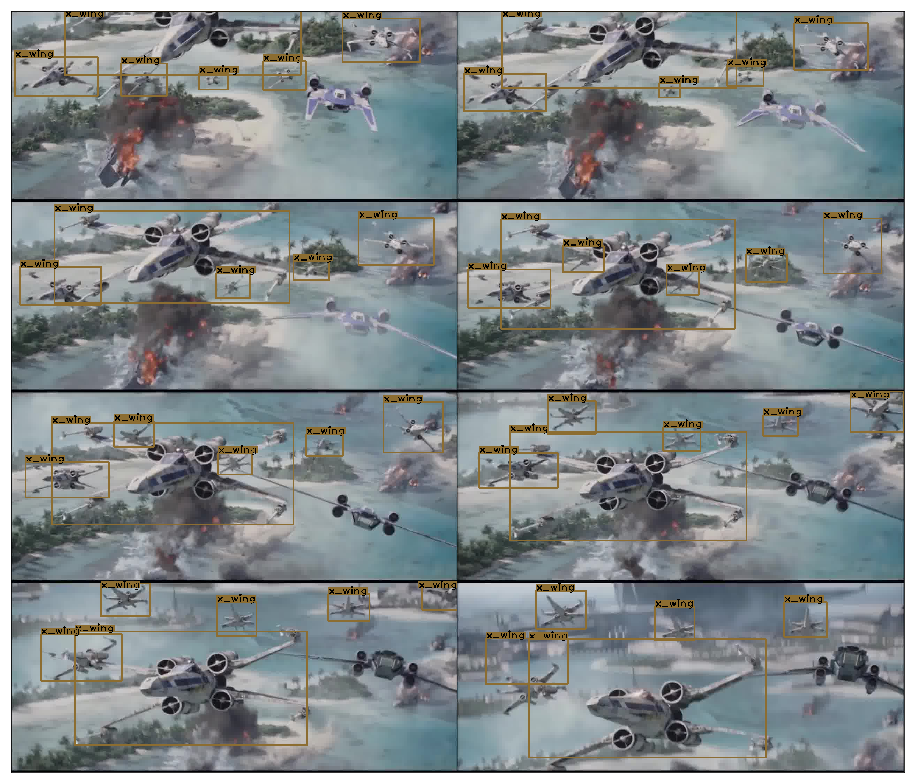

In [19]:
# Display subset of the training set
start = 200
subset_idx = np.arange(start, start + 8)
output_img_dir, output_label_dir = test_model('x_wing_5', classes_names,
                                              subset_idx=subset_idx,
                                              isDisplay=True, isSaveImg=False, isSaveLabel=False)

Loading ./weights/x_wing_5/yolov3_x_wing_5_checkpoint_0259.pth.tar
./output/x_wing_5/img/x_wing_0379.jpg
./output/x_wing_5/img/x_wing_0380.jpg
./output/x_wing_5/img/x_wing_0381.jpg
./output/x_wing_5/img/x_wing_0382.jpg
./output/x_wing_5/img/x_wing_0383.jpg
./output/x_wing_5/img/x_wing_0384.jpg
./output/x_wing_5/img/x_wing_0385.jpg
./output/x_wing_5/img/x_wing_0386.jpg


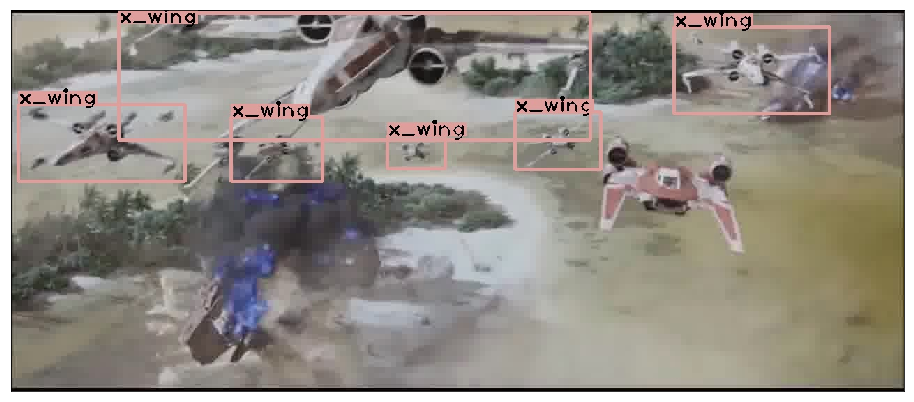

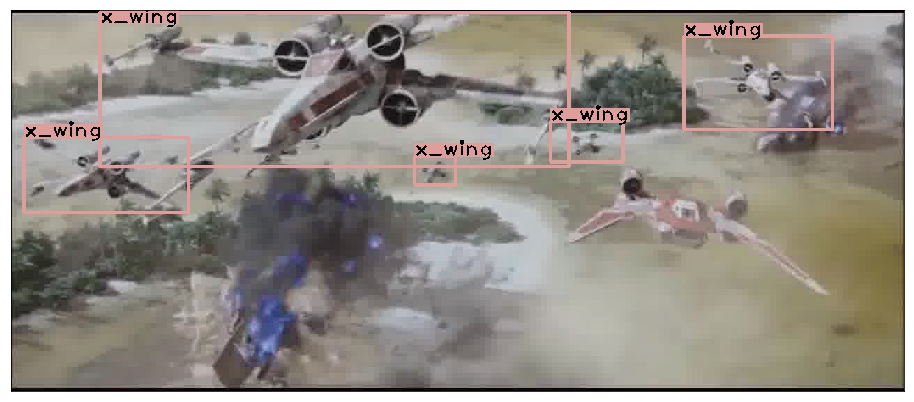

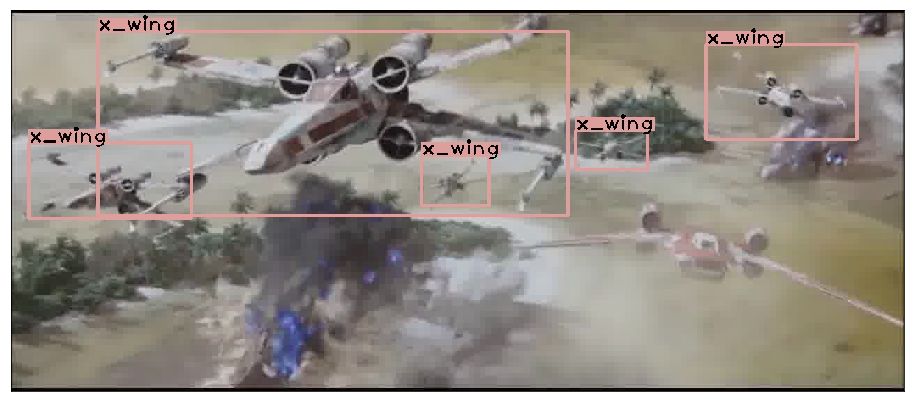

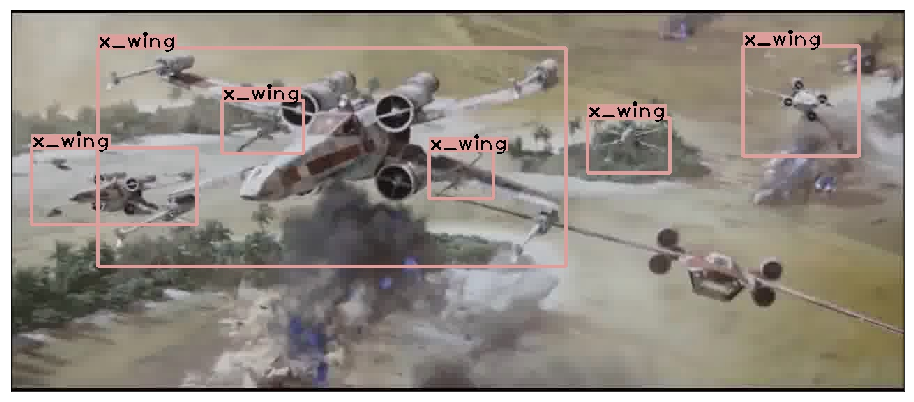

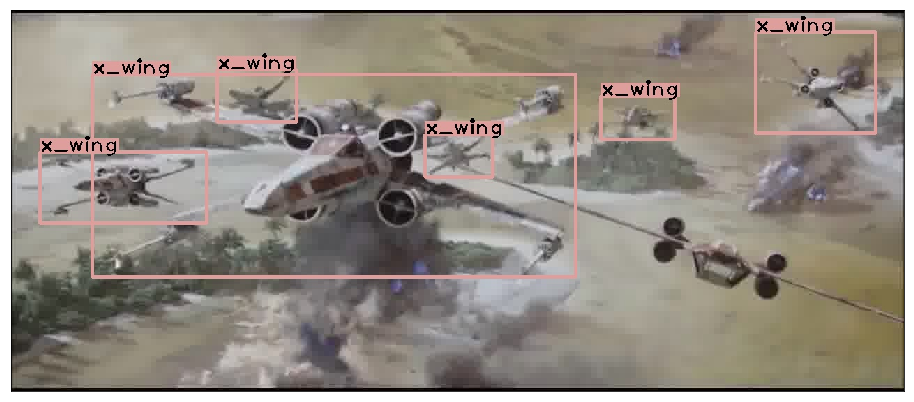

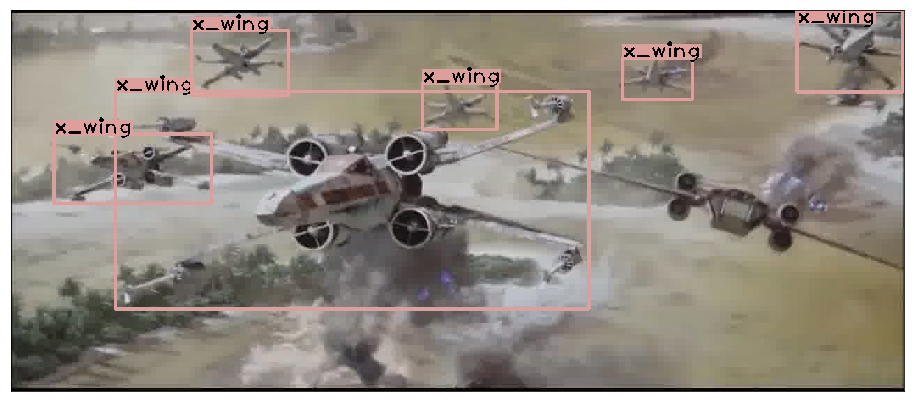

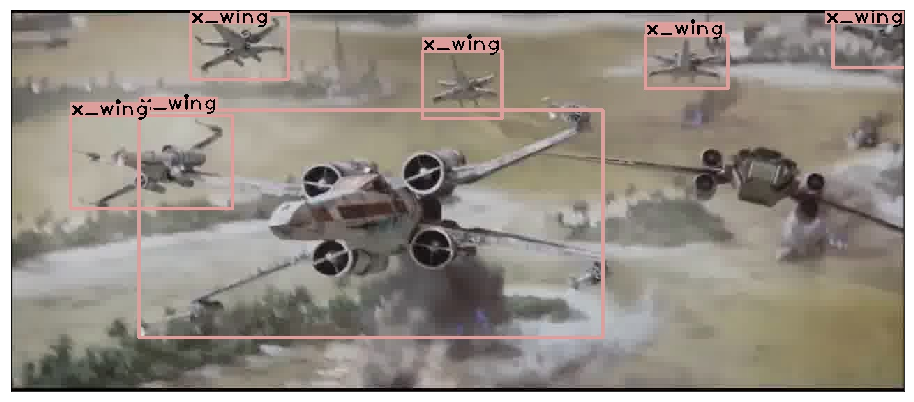

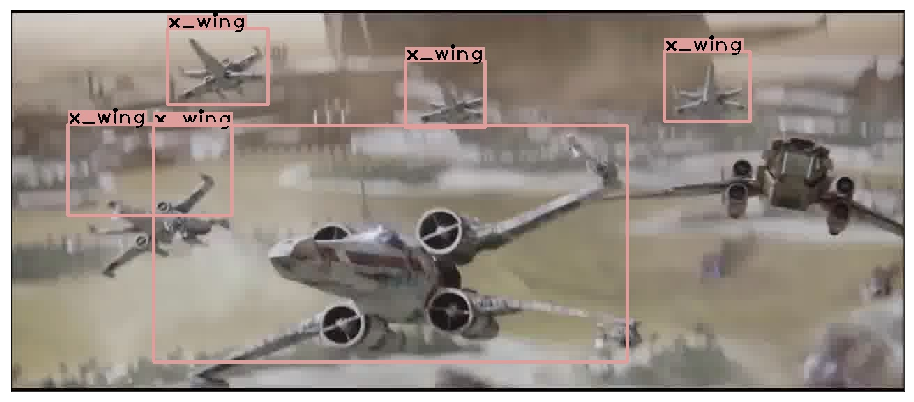

In [20]:
# Save detections
output_img_dir, output_label_dir = test_model('x_wing_5', classes_names,
                                              subset_idx=None,
                                              isDisplay=False, isSaveImg=True, isSaveLabel=True)
read_detections(output_img_dir, 200, 8)